<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Mod%C3%A9lisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np
import random as rd

In [16]:
rd.seed(42)

Import des bases : 
- *df* contient la base TMDb
- *train_review* contient la partie entraînée sur les reviews labellisés
- *test_review* contient la partie test sur les reviews labellisés





In [21]:
 df = pd.read_csv('https://raw.githubusercontent.com/marie-ganon/Projet-Python-S1/main/Bases_import%C3%A9es/base.csv')

Avant de modéliser quoi que ce soit, nous allons supprimer les 'NaN' de la base de données.

In [5]:
df = df.dropna()
df = df.drop(columns='Unnamed: 0')

In [7]:
# Fichier temporaire

import tempfile

temp_dir = tempfile.mkdtemp()

# Pour dezipper le csv disponible dans le git 

import zipfile

with zipfile.ZipFile('test_review.csv.zip', 'r') as zip1, zipfile.ZipFile('train_review.csv.zip', 'r') as zip2 :
    zip1.extractall('temp_dir')
    zip2.extractall('temp_dir')

test_review = pd.read_csv(r'temp_dir/test_review.csv', sep=',', low_memory = False)
train_review = pd.read_csv(r'temp_dir/train_review.csv', sep=',', low_memory = False)


FileNotFoundError: ignored

# Analyse de la matrice de corrélation de la base

Rappelons la matrice de corrélation de la base :

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count,collection,score_1,production_companies_id,pc_id_count
index,1.000000,-0.111052,0.675912,-0.113959,-0.083023,-0.171586,-0.239960,-0.071127,-0.102720,-0.072469,0.331970,-0.229618
budget,-0.111052,1.000000,-0.086690,0.412162,0.766446,0.225766,0.103634,0.665415,0.212146,0.622080,-0.160624,0.117158
id,0.675912,-0.086690,1.000000,-0.014127,-0.060123,-0.086692,-0.141201,-0.033574,-0.122764,-0.034831,0.367358,-0.186671
popularity,-0.113959,0.412162,-0.014127,1.000000,0.495219,0.161276,0.186538,0.544388,0.184730,0.534342,-0.143197,0.050937
revenue,-0.083023,0.766446,-0.060123,0.495219,1.000000,0.183763,0.137679,0.806602,0.284759,0.780984,-0.125020,0.108120
runtime,-0.171586,0.225766,-0.086692,0.161276,0.183763,1.000000,0.231019,0.199476,-0.016943,0.200588,-0.105164,0.068359
vote_average,-0.239960,0.103634,-0.141201,0.186538,0.137679,0.231019,1.000000,0.203592,0.019937,0.212963,-0.116379,0.048969
vote_count,-0.071127,0.665415,-0.033574,0.544388,0.806602,0.199476,0.203592,1.000000,0.246816,0.994176,-0.134497,0.080398
collection,-0.102720,0.212146,-0.122764,0.184730,0.284759,-0.016943,0.019937,0.246816,1.000000,0.228573,-0.100320,0.036184
score_1,-0.072469,0.622080,-0.034831,0.534342,0.780984,0.200588,0.212963,0.994176,0.228573,1.000000,-0.126350,0.075440


Par construction de *score_1*, il n'est pas choquant d'observer une forte corrélation avec *popularity*, *vote_count* et *vote_average*.

On constate que bien qu'il y ait peu de données qui puissent être exploitées pour le budget et le revenu d'un film, ces deux variables sont cependant corrélées avec *score_1*, qui permet de quantifier la qualité d'un film.

Par ailleurs, la compagnie de production et la durée du film ne semblent guère influencer sa qualité. 

# Régression linéaire de *score_1* sur *budget* et *revenue*

Tout d'abord, récupérons les données nécessaires dans le dataset.

In [ ]:
X = pd.DataFrame(np.c_[df.budget, df.revenue], columns= ['budget', 'revenue'])
Y = df.score_1

Séparons ensuite nos deux ensembles de données en bases d'apprentissage et de test.

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13884, 2)
(3472, 2)
(13884,)
(3472,)


On effectue alors la régression linéaire voulue.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluons les performances du modèle sur l'échantillon d'apprentissage et sur celui de test :

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 3467.4302151622496
Le score R² est 0.6162165165800999


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 3364.076265294737
Le score R² est 0.5879873205932651


Bien que le R² soit plutôt bon, ce modèle génère une erreur quadratique moyenne assez forte sur la valeur de *score_1* (de l'ordre de 3400). Cela est certainement dû à la dispersion de score_1 :

In [ ]:
df.score_1.describe()

count     17356.000000
mean       1709.543046
std        5527.962377
min           0.000000
25%          44.800000
50%         170.000000
75%         857.700000
max      114007.500000
Name: score_1, dtype: float64

Etudions les perfomances de ce modèle sur un échantillon comprenant les valeurs de *score_1* allant du 1er au 3ème quartile :

In [ ]:
first_quart = np.percentile(df.score_1, 25)
third_quart = np.percentile(df.score_1, 75)

In [ ]:
# Filtration des données
df_quart = df[df.score_1 > first_quart]
df_quart = df[df.score_1 < third_quart]

# Création des variables nécessaires
X2 = pd.DataFrame(np.c_[df_quart.budget, df_quart.revenue], columns= ['budget', 'revenue'])
Y2 = df_quart.score_1
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.2, random_state=5)

# Lancement de la régression linéaire
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train2, Y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict2 = lmodellineaire.predict(X_train2)
rmse = (np.sqrt(mean_squared_error(Y_train2, y_train_predict2)))
r2 = r2_score(Y_train2, y_train_predict2)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict2 = lmodellineaire.predict(X_test2)
rmse = (np.sqrt(mean_squared_error(Y_test2, y_test_predict2)))
r2 = r2_score(Y_test2, y_test_predict2)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 188.1704456835393
Le score R² est 0.1454504867917935


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 181.4256396942466
Le score R² est 0.1529228653745578


Par cette nouvelle régression, nous avons certes diminué drastiquement l'erreur quadratique moyenne, cependant le R² a été divisé par 4.

Comparons graphiquement les résultats de la prédiction pour ces deux régressions.

In [ ]:
def plot(test, predict):
  fig, ax = plt.subplots(figsize=(8,5))
  p1 = sns.distplot(test, label = 'Vraie valeur')
  p2 = sns.distplot(predict, label = 'Prédiction')
  ax.set(xlabel= 'Valeur de score_1', ylabel = 'Densité')
  fig.legend(labels=['Vraie valeur','Prédiction'], loc = (0.75, 0.5))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

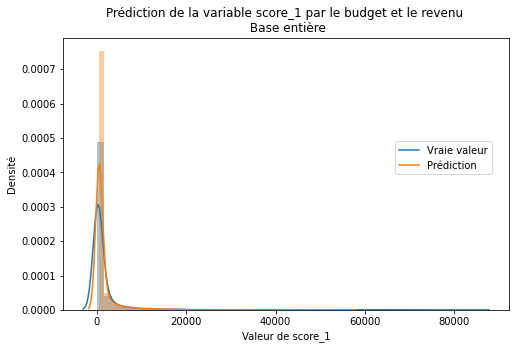

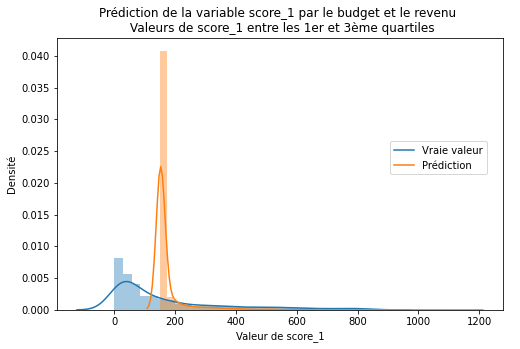

In [ ]:
plot(Y_test,y_test_predict)
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Base entière')

plot(Y_test2, y_test_predict2)
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Valeurs de score_1 entre les 1er et 3ème quartiles')

plt.show()

Grâce à ces graphiques, on remarque qu'effectivement la première régression est nettement plus efficace que la seconde pour prédire les valeurs de *score_1*. Cependant, l'algorithme a plus de mal à prédire précisément les petites valeurs de *score_1*.

# Sentiment analysis (?)


On va tenter d'enrichir notre base en rajoutant l'analyse sentiment des commentaires associés aux films. Pour cela, on importe les base *train_review.csv.zip* et *test_review.csv.zip*. 


In [9]:
# Création d'un dossier temporaire

import tempfile

temp_dir = tempfile.mkdtemp()

In [8]:
# Pour dezipper les csv disponibles dans le git
import zipfile
# test_review
zip_ref = zipfile.ZipFile('/content/test_review.csv.zip', 'r')
zip_ref.extractall('/content/temp_dir')
zip_ref.close()

In [12]:
# train_review
zip_ref = zipfile.ZipFile('/content/train_review2.csv.zip', 'r')
zip_ref.extractall('/content/temp_dir')
zip_ref.close()

In [18]:
train_review = pd.read_csv(r'temp_dir/train_review.csv', sep=',', low_memory = False)

test_review = pd.read_csv(r'temp_dir/test_review.csv', sep=',', low_memory = False)

On va garder les *review* des films présents dans la base *df*.

In [35]:
l = []
l_rtest = pd.unique(test_review.imdb_id)
l_rtrain = pd.unique(train_review.imdb_id)
for elem in df.imdb_id:
  if elem in l_rtest or elem in l_rtrain : 
    l.append(elem)


In [51]:
cond = test_review.apply ( lambda row : row['imdb_id'] in l , axis = 1 )
test_filtered = test_review[cond]

print('On a supprimé', len(test_review)-len(test_filtered), 'reviews de films non attribués dans la base')

On a supprimé 9340 reviews de films non attribués dans la base


In [52]:
cond = train_review.apply ( lambda row : row['imdb_id'] in l , axis = 1 )
train_filtered = train_review[cond]

On va pouvoir associer les deux dataframe construits. 

In [59]:
review_filtered = pd.concat([train_filtered, test_filtered])

On tokenize puis on enlève les stopwords.

In [65]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

reviews = review_filtered.review.str.cat(sep=' ')
# on découpe selon les mots
tokens = word_tokenize(reviews)
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
words=[word.lower() for word in tokens if word.isalpha()]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
vocabulary = set(words)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(words)
print('les 10 mots les plus fréquents',sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:20])


81153
les 10 mots les plus fréquents ['like', 'good', 'would', 'even', 'time', 'really', 'see', 'story', 'well', 'much', 'could', 'great', 'get', 'also', 'people', 'first', 'bad', 'make', 'made', 'way']


Il y a encore quelques stop words qu'on va retirer. On rajoute les mots pertinents à retirer dans la liste *to_remove* jusqu'à ce que la liste des 10 mots les plus fréquents contienne des termes sans stopwords ainsi qu'uniquement des mots pertinents (par exemple *movies* ou *film* ne sont pas très pertinents puisque tous les objets sont des films ici).

In [80]:
to_remove = ['i','br', 'the','this', 'it', 'one', 'movie', 'film']
words = [word for word in words if word not in to_remove]

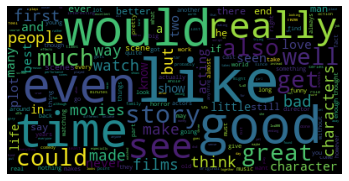

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
vocabulary = set(words)
frequency_dist = nltk.FreqDist(words)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Comme nous utilisons des subsets des bases d'apprentissage et d'entraînement initialement fournies, nous allons recréer ces bases pour notre modèle de sentiment analysis. 

In [84]:
print(len(train_filtered), len(test_filtered))

16569 15660


In [86]:
x_train = train_filtered.loc[:15660, 'review'].values
y_train = train_filtered.loc[:15660, 'sentiment'].values
x_test = test_filtered['review'].values
y_test = test_filtered['sentiment'].values

On préprocess le texte avec *TFidfTransformer* : 

In [88]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
print(train_vectors.shape, test_vectors.shape)

(10025, 51153) (15660, 51153)


On utilise un classifier naïf bayésien pour entraîner notre modèle.

In [90]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)

Maintenant que le modèle est entraîné, on s'intéresse au score :

In [92]:
from  sklearn.metrics  import accuracy_score
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))


0.4722860791826309


On obtient un score de 47,23%. 